### Import packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import plotly.express as px

import copy
import seaborn as sns
import os
from scipy import stats
import datetime

import sqlite3 as sqlite
from sqlalchemy import create_engine
%matplotlib inline

In [5]:
data_path = '/mnt/d/lighthouse/Midterm_data/'

In [6]:
# 2350497 rows × 38 columns
flights = pd.read_csv(data_path + 'flights_cleaned.csv', header = 0)
flights.drop('Unnamed: 0', axis = 1, inplace = True)
passengers = pd.read_csv(data_path + 'passengers.csv', header = 0)
flights_outlier = pd.read_csv(data_path + 'flights_outliers_no_encode.csv', header = 0)
flights_outlier.drop('Unnamed: 0', axis =1, inplace = True)

In [7]:
passengers_haul = copy.deepcopy(passengers)
flights_haul = copy.deepcopy(flights)
flights_outlier_haul = copy.deepcopy(flights_outlier)

In [8]:
flights_outlier_haul = flights_outlier_haul[['dep_time', 'arr_time', 'air_time', 'year','month','date']]
flights_outlier_haul = flights_outlier_haul[flights_outlier_haul['air_time']>0]

In [9]:
flights_outlier_haul

,dep_time,arr_time,air_time,year,month,date
0,1753.0,1838.0,152.0,2019,3,25
1,1955.0,2036.0,149.0,2019,3,25
2,541.0,625.0,149.0,2019,3,25
3,1729.0,2039.0,116.0,2019,3,25
4,1331.0,1702.0,141.0,2019,3,25
...,...,...,...,...,...,...
15605071,2111.0,2242.0,84.0,2019,3,25
15605072,1328.0,1534.0,232.0,2019,3,25
15605073,915.0,1052.0,207.0,2019,3,25
15605074,1123.0,1204.0,146.0,2019,3,25


### exploring air_time

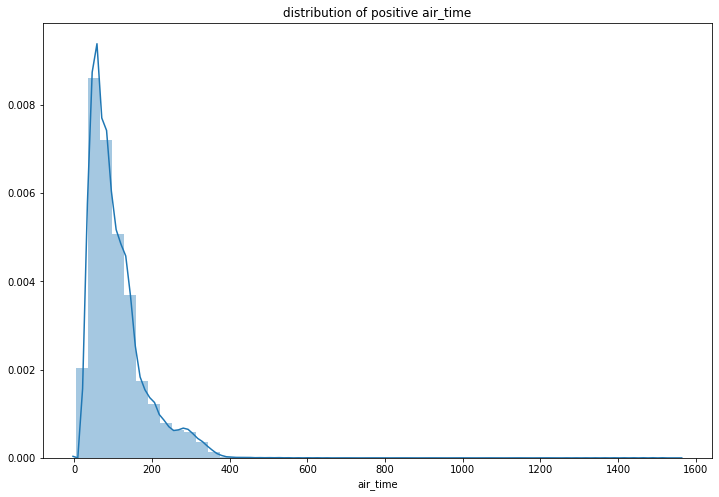

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(flights_outlier_haul['air_time'])
ax.set_title('distribution of positive air_time')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_8_positive_air_time.png')

In [11]:
flights_outlier_haul['air_time'].describe()

count    1.560507e+07
mean     1.079548e+02
std      6.968195e+01
min      4.000000e+00
25%      5.800000e+01
50%      8.900000e+01
75%      1.370000e+02
max      1.557000e+03
Name: air_time, dtype: float64

### categorizing into short, medium and long

In [12]:
flights_outlier_haul['air_time_cate'] = np.where(flights_outlier_haul['air_time']<=70,0,flights_outlier_haul['air_time'])
flights_outlier_haul['air_time_cate'] = np.where((flights_outlier_haul['air_time']<=120)&(70<flights_outlier_haul['air_time']),1,flights_outlier_haul['air_time_cate'])
flights_outlier_haul['air_time_cate'] = np.where(120<flights_outlier_haul['air_time'],2,flights_outlier_haul['air_time_cate'])

In [13]:
flights_outlier_haul

,dep_time,arr_time,air_time,year,month,date,air_time_cate
0,1753.0,1838.0,152.0,2019,3,25,2.0
1,1955.0,2036.0,149.0,2019,3,25,2.0
2,541.0,625.0,149.0,2019,3,25,2.0
3,1729.0,2039.0,116.0,2019,3,25,1.0
4,1331.0,1702.0,141.0,2019,3,25,2.0
...,...,...,...,...,...,...,...
15605071,2111.0,2242.0,84.0,2019,3,25,1.0
15605072,1328.0,1534.0,232.0,2019,3,25,2.0
15605073,915.0,1052.0,207.0,2019,3,25,2.0
15605074,1123.0,1204.0,146.0,2019,3,25,2.0


In [14]:
# short: 5683322
# medium: 4832074
# long: 5089675
flights_short = copy.deepcopy(flights_outlier_haul[flights_outlier_haul['air_time_cate']==0])
flights_medium = copy.deepcopy(flights_outlier_haul[flights_outlier_haul['air_time_cate']==1])
flights_long = copy.deepcopy(flights_outlier_haul[flights_outlier_haul['air_time_cate']==2])

### short, medium and long flights

Text(0.5, 1.0, 'long haul flights')

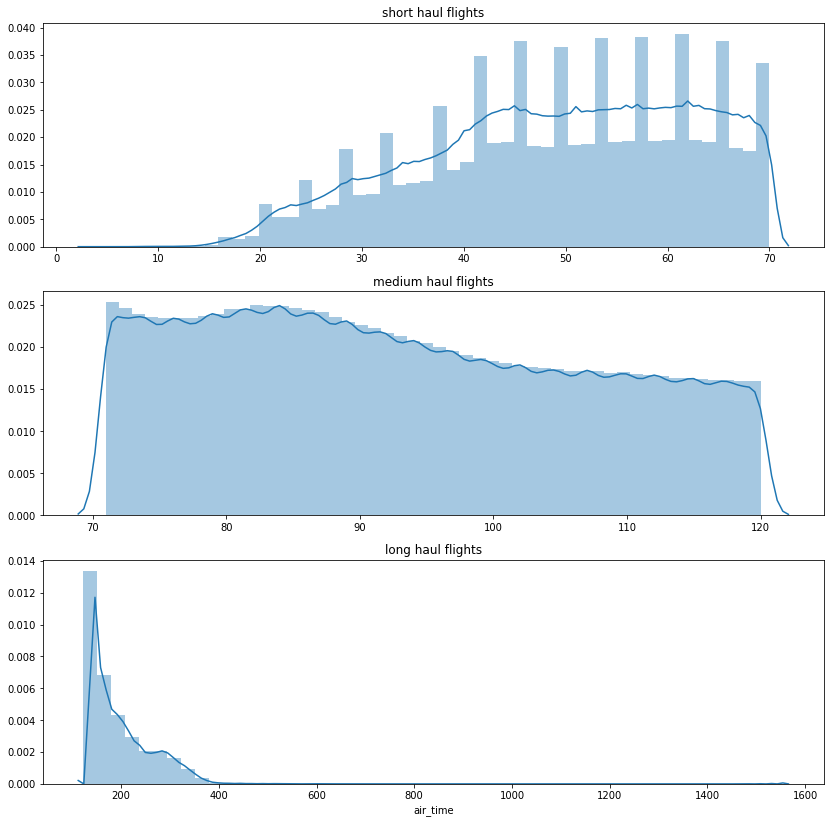

In [15]:
fig, ax = plt.subplots(3,figsize=(14,14))
sns.distplot(flights_outlier_haul[flights_outlier_haul['air_time_cate']==0]['air_time'], ax=ax[0])
sns.distplot(flights_outlier_haul[flights_outlier_haul['air_time_cate']==1]['air_time'], ax=ax[1])
sns.distplot(flights_outlier_haul[flights_outlier_haul['air_time_cate']==2]['air_time'], ax=ax[2])
ax[0].set_title('short haul flights')
ax[1].set_title('medium haul flights')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_title('long haul flights')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_8_bin_air_time.png')

In [16]:
sum_table = pd.DataFrame([flights_short['air_time'].describe(),flights_medium['air_time'].describe(),flights_long['air_time'].describe()])
sum_table = sum_table.reset_index(drop=True)
sum_table.rename(index={0:'short',1:'medium',2:'long'})

,count,mean,std,min,25%,50%,75%,max
short,5683322.0,49.233434,13.154234,4.0,40.0,50.0,60.0,70.0
medium,4832074.0,93.239214,14.211966,71.0,81.0,92.0,105.0,120.0
long,5089675.0,187.495978,64.183817,121.0,138.0,164.0,220.0,1557.0


### Countplot over the day

In [18]:
flights_short['dep_hour'] = (((flights_short['dep_time'].astype(int)).astype(str)).str.rjust(4,'0')).str[:2]
flights_medium['dep_hour'] = (((flights_medium['dep_time'].astype(int)).astype(str)).str.rjust(4,'0')).str[:2]
flights_long['dep_hour'] = (((flights_long['dep_time'].astype(int)).astype(str)).str.rjust(4,'0')).str[:2]

Text(0.5, 0, '')

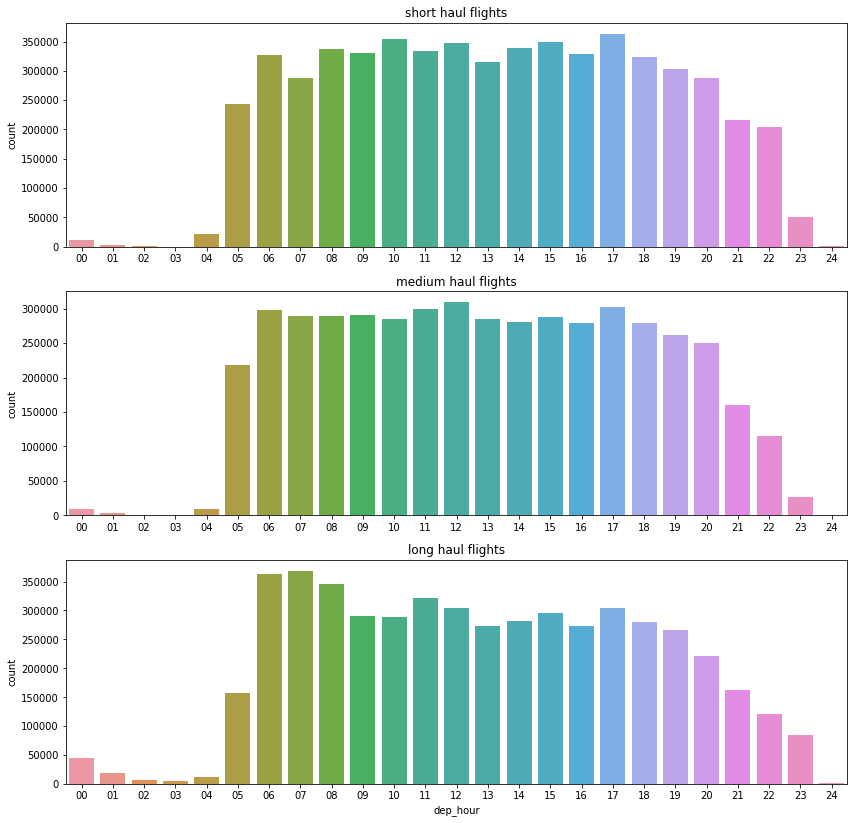

In [19]:
fig, ax = plt.subplots(3,figsize=(14,14))
sns.countplot(flights_short['dep_hour'], ax=ax[0])
sns.countplot(flights_medium['dep_hour'], ax=ax[1])
sns.countplot(flights_long['dep_hour'], ax=ax[2])
ax[0].set_title('short haul flights')
ax[1].set_title('medium haul flights')
ax[2].set_title('long haul flights')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
#plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_8_flights_count_plot.png')

### using google threshholds

In [60]:
flights_outlier_haul['air_time_cate'] = np.where(flights_outlier_haul['air_time']<=180,0,flights_outlier_haul['air_time'])
flights_outlier_haul['air_time_cate'] = np.where((flights_outlier_haul['air_time']<=360)&(180<flights_outlier_haul['air_time']),1,flights_outlier_haul['air_time_cate'])
flights_outlier_haul['air_time_cate'] = np.where(360<flights_outlier_haul['air_time'],2,flights_outlier_haul['air_time_cate'])

In [61]:
flights_short = copy.deepcopy(flights_outlier_haul[flights_outlier_haul['air_time_cate']==0])
flights_medium = copy.deepcopy(flights_outlier_haul[flights_outlier_haul['air_time_cate']==1])
flights_long = copy.deepcopy(flights_outlier_haul[flights_outlier_haul['air_time_cate']==2])

In [62]:
#13525221
flights_short = copy.deepcopy(flights_outlier_haul[flights_outlier_haul['air_time_cate']==0])
# 2022586
flights_medium = copy.deepcopy(flights_outlier_haul[flights_outlier_haul['air_time_cate']==1])
# 57264
flights_long = copy.deepcopy(flights_outlier_haul[flights_outlier_haul['air_time_cate']==2])

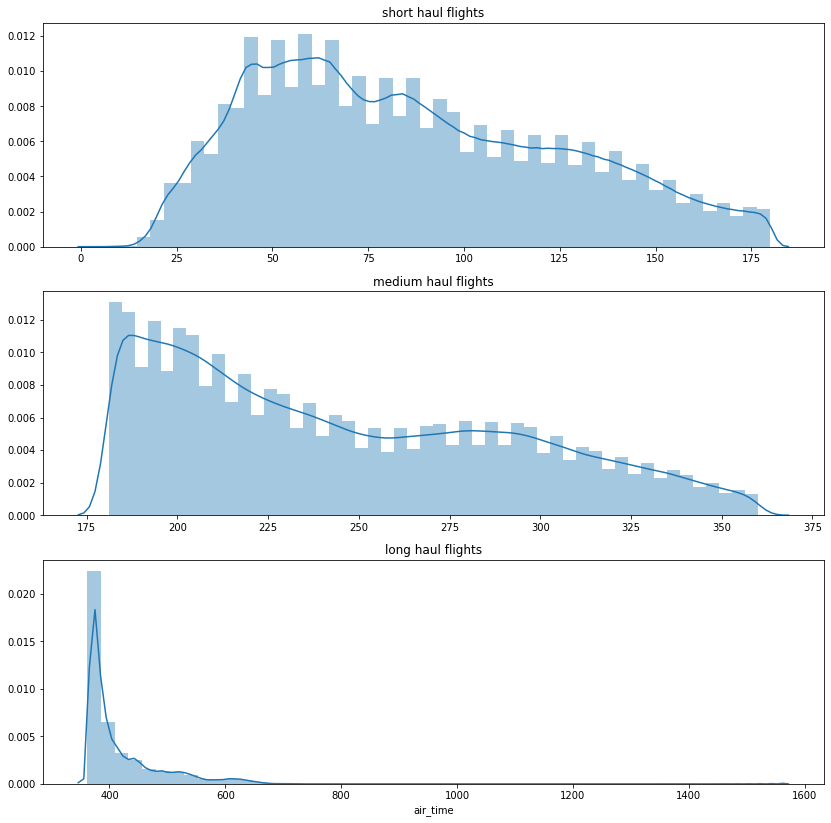

In [65]:
fig, ax = plt.subplots(3,figsize=(14,14))
sns.distplot(flights_outlier_haul[flights_outlier_haul['air_time_cate']==0]['air_time'], ax=ax[0])
sns.distplot(flights_outlier_haul[flights_outlier_haul['air_time_cate']==1]['air_time'], ax=ax[1])
sns.distplot(flights_outlier_haul[flights_outlier_haul['air_time_cate']==2]['air_time'], ax=ax[2])
ax[0].set_title('short haul flights')
ax[1].set_title('medium haul flights')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_title('long haul flights')
plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_8_bin_air_time_google.png')

In [66]:
sum_table = pd.DataFrame([flights_short['air_time'].describe(),flights_medium['air_time'].describe(),flights_long['air_time'].describe()])
sum_table = sum_table.reset_index(drop=True)
sum_table.rename(index={0:'short',1:'medium',2:'long'})

,count,mean,std,min,25%,50%,75%,max
short,13525221.0,86.094457,39.301239,4.0,54.0,80.0,116.0,180.0
medium,2022586.0,245.601538,48.009669,181.0,203.0,235.0,284.0,360.0
long,57264.0,409.420316,63.376410,361.0,368.0,382.0,425.0,1557.0


In [68]:
flights_short['dep_hour'] = (((flights_short['dep_time'].astype(int)).astype(str)).str.rjust(4,'0')).str[:2]
flights_medium['dep_hour'] = (((flights_medium['dep_time'].astype(int)).astype(str)).str.rjust(4,'0')).str[:2]
flights_long['dep_hour'] = (((flights_long['dep_time'].astype(int)).astype(str)).str.rjust(4,'0')).str[:2]

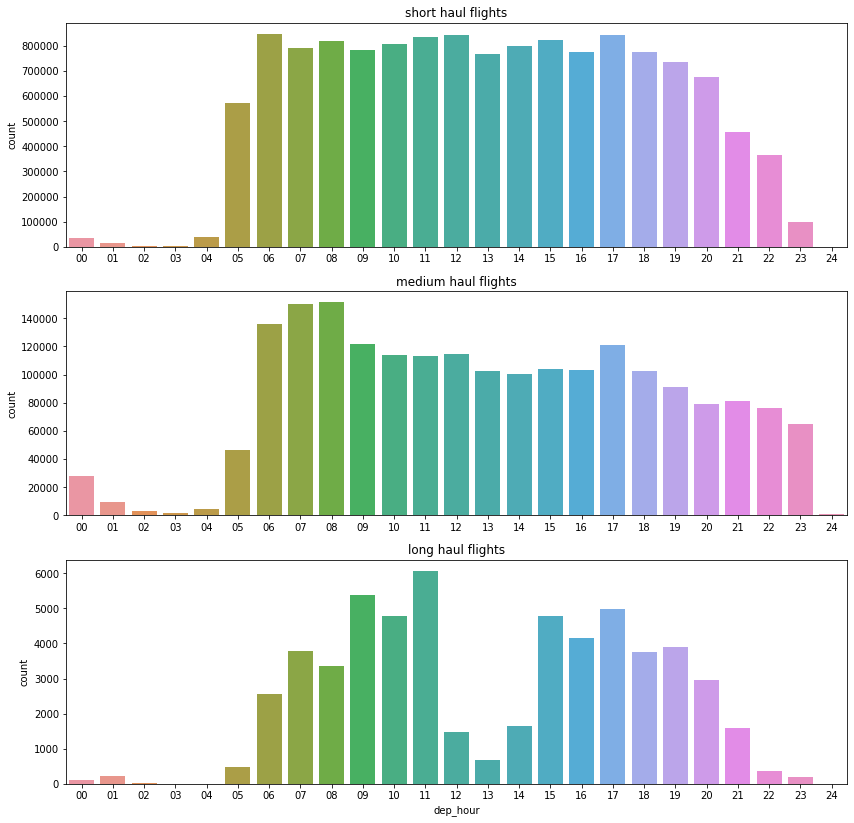

In [70]:
fig, ax = plt.subplots(3,figsize=(14,14))
sns.countplot(flights_short['dep_hour'], ax=ax[0])
sns.countplot(flights_medium['dep_hour'], ax=ax[1])
sns.countplot(flights_long['dep_hour'], ax=ax[2])
ax[0].set_title('short haul flights')
ax[1].set_title('medium haul flights')
ax[2].set_title('long haul flights')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.savefig('/mnt/d/lighthouse/Midterm/visualization/Task_8_flights_count_plot_google.png')

## Short and medium flights take off around the same time starting at 5 in the morning, whilst long flights are more concentrated around the morning and late evening